# Analyzing CIA Factbook Data Using SQL

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyzing-CIA-Factbook-Data-Using-SQL" data-toc-modified-id="Analyzing-CIA-Factbook-Data-Using-SQL-1">Analyzing CIA Factbook Data Using SQL</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Connecting-to-Our-Database" data-toc-modified-id="Connecting-to-Our-Database-1.2">Connecting to Our Database</a></span></li><li><span><a href="#Data-Overview" data-toc-modified-id="Data-Overview-1.3">Data Overview</a></span></li><li><span><a href="#Summary-Statistics" data-toc-modified-id="Summary-Statistics-1.4">Summary Statistics</a></span></li><li><span><a href="#Average-Population-and-Area" data-toc-modified-id="Average-Population-and-Area-1.5">Average Population and Area</a></span><ul class="toc-item"><li><span><a href="#Countries-with-Above-Average-Population-and-Low-Total-Area" data-toc-modified-id="Countries-with-Above-Average-Population-and-Low-Total-Area-1.5.1">Countries with Above Average Population and Low Total Area</a></span></li></ul></li><li><span><a href="#Land-to-Sea-Proportions" data-toc-modified-id="Land-to-Sea-Proportions-1.6">Land to Sea Proportions</a></span></li><li><span><a href="#Birth-to-Death" data-toc-modified-id="Birth-to-Death-1.7">Birth to Death</a></span></li><li><span><a href="#Replacement-Rate-and-Population-Density" data-toc-modified-id="Replacement-Rate-and-Population-Density-1.8">Replacement Rate and Population Density</a></span></li></ul></li></ul></div>

## Introduction

In this project, we'll work with data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/), a compendium, of statistics about all of the couintries on Earth. The Factbook contains demographic information like the following:
* population - the global population
* popuilation_growth - thet annual population growth rate, as a percentage
* area - the total land and water area

## Connecting to Our Database

In [1]:
# code required to work on a local SQL DB

In [2]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [3]:
# show the available tables in the local db

In [4]:
%%sql
SELECT * 
  FROM sqlite_master
 WHERE type = 'table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


## Data Overview

In [5]:
# show the first five rows of the facts db

In [6]:
%%sql
SELECT *
  FROM facts
 LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the desciptions of some of the key columns:
* name — the name of the country.
* area— the country's total area (both land and water).
* area_land — the country's land area in square kilometers.
* area_water — the country's waterarea in square kilometers.
* population — the country's population.
* population_growth— the country's population growth as a percentage.
* birth_rate — the country's birth rate, or the number of births per year per 1,000 people.
* death_rate — the country's death rate, or the number of death per year per 1,000 people.
* migration_rate - the number of persons entering a country during the year per 1,000 persons (based on midyear population).

## Summary Statistics

In [7]:
%%sql
SELECT MIN(population),
       MAX(population),
       MIN(population_growth),
       MAX(population_growth)
  FROM facts

 * sqlite:///factbook.db
Done.


MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,7256490011,0.0,4.02


There are outliers here that indicate some potential issues with our data. There is a country with a population of 0 and another with a population of over 7 billion. 

In [8]:
# countries with the min population

In [9]:
%%sql
SELECT name,
       population
  FROM facts
 WHERE population = 0 OR population > 7000000000
 GROUP BY name;

 * sqlite:///factbook.db
Done.


name,population
Antarctica,0
World,7256490011


The MIN-MAX results make sense in light of this new query. There is a summary row that tells us the population of all the countries in the world, with name 'World'. Antarctica is the reason for our 0 population outlier, Antarctica being a vast Arctic Tundra with little inhabitable land. 

Let's rerun our summary statistcs while excluding the 'World' total row.

In [10]:
%%sql
SELECT MIN(population),
       MAX(population),
       MIN(population_growth),
       MAX(population_growth)
  FROM facts
 WHERE population < 7000000000

 * sqlite:///factbook.db
Done.


MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,1367485388,0.0,4.02


The most populous country has 1.38 billion people.

## Average Population and Area

Density can be understood as a proportion of people to land area. Let's explore this idea using our dataset.

In [11]:
# what is the average population of our columns and what is the 

In [12]:
%%sql 
SELECT CAST(ROUND(AVG(population),0) AS INT) AS 'average_population',
       CAST(ROUND(AVG(area),0) AS INT) AS 'average_area_km', 
       ROUND(AVG(population) / AVG(area), 0) AS 'pop_density'
  FROM facts
 WHERE name != 'World';

 * sqlite:///factbook.db
Done.


average_population,average_area_km,pop_density
32242667,555094,58.0


The average country has a population of roughly 32,000,000 and an area of 555,000 kilometers. The population density can be interpreted as there are roughly 58 people per square kilometer, on average, in countries across the world.

### Countries with Above Average Population and Low Total Area

In [13]:
%%sql
SELECT name,
       population,
       area,
       population / area AS 'pop_density'

  FROM facts
 WHERE population > (SELECT CAST(ROUND(AVG(population),0) AS INT) AS 'average_population'
                       FROM facts
                      WHERE name <> 'World')
       AND area < (SELECT CAST(ROUND(AVG(area),0) AS INT) AS 'average_area_km'
                     FROM facts
                    WHERE name <> 'World')
       AND name != 'World'
 ORDER BY pop_density DESC;

 * sqlite:///factbook.db
Done.


name,population,area,pop_density
Bangladesh,168957745,148460,1138
"Korea, South",49115196,99720,492
Philippines,100998376,300000,336
Japan,126919659,377915,335
Vietnam,94348835,331210,284
United Kingdom,64088222,243610,263
Germany,80854408,357022,226
Italy,61855120,301340,205
Uganda,37101745,241038,153
Thailand,67976405,513120,132


Of the countries with above average populations and below average land area, the most densly populated country is Bangladesh, which has an average population density of 1,138 people per square Kilometer.

## Land to Sea Proportions

In [14]:
%%sql
SELECT name,
       area,
       area_land,
       area_water,
       area_land / area_water AS land_water_ratio
  FROM facts
 WHERE name != 'World' AND land_water_ratio IS Null
 ORDER BY area_land DESC;

 * sqlite:///factbook.db
Done.


name,area,area_land,area_water,land_water_ratio
Algeria,2381741,2381741,0,None
Greenland,2166086,2166086,None,None
Saudi Arabia,2149690,2149690,0,None
Libya,1759540,1759540,0,None
Angola,1246700,1246700,0,None
Mauritania,1030700,1030700,0,None
Afghanistan,652230,652230,0,None
Central African Republic,622984,622984,0,None
Yemen,527968,527968,0,None
Oman,309500,309500,0,None


We see that there is a significant number of countries with either no datapoint or zero for area of water. While many of these could be landlocked or desert countries, we see countries here that should logically have entries for water. Some clear examples being New Zealand, Fiji, Greenland, which are all islands. We either have bad data or do not understand the measurement methodology to conduct a fair analysis. 

## Birth to Death

To find the velocity at which a population is increasing (or decreasing) in a given country, we can subtract our birth rate from our death rate to get our rate of replacement. 

This is not the same as population_growth, which considers immigration and emigration.

In [15]:
%%sql
SELECT *
  FROM facts

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46
6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21
7,ar,Argentina,2780400,2736690,43710,43431886,0.93,16.64,7.33,0.0
8,am,Armenia,29743,28203,1540,3056382,0.15,13.61,9.34,5.8
9,as,Australia,7741220,7682300,58920,22751014,1.07,12.15,7.14,5.65
10,au,Austria,83871,82445,1426,8665550,0.55,9.41,9.42,5.56


In [16]:
%%sql
SELECT AVG(birth_rate - death_rate) AS average_replacement_rate
  FROM facts
 WHERE name != 'World'

 * sqlite:///factbook.db
Done.


average_replacement_rate
11.51039647577092


The average rate for a country's replacement rate is 11.5. (This is not the same as the World's replacement rate).

Let's start by looking at country's above the average rate of replacement, where we look at how births and deaths net out for a country.

In [17]:
%%sql
SELECT name,
       birth_rate,
       death_rate,
       birth_rate - death_rate AS replacement_rate
  FROM facts
 WHERE name != 'World' AND
       replacement_rate IS NOT Null
 ORDER BY replacement_rate;

 * sqlite:///factbook.db
Done.


name,birth_rate,death_rate,replacement_rate
Bulgaria,8.92,14.44,-5.52
Serbia,9.08,13.66,-4.58
Latvia,10.0,14.31,-4.3100000000000005
Lithuania,10.1,14.27,-4.17
Ukraine,10.72,14.46,-3.74
Hungary,9.16,12.73,-3.5700000000000003
Germany,8.47,11.42,-2.9499999999999993
Slovenia,8.42,11.37,-2.9499999999999993
Romania,9.14,11.9,-2.76
Croatia,9.45,12.18,-2.7300000000000004


There are many countries in population decline and, interestingly, most of those countries are European. Conversely, the countries with the highest birth rates are in the Middle East and Africa.

To add more context to our analysis, let's look at the most and least populous countries.

In [18]:
%%sql
SELECT name,
       population,
       birth_rate - death_rate AS replacement_rate
  FROM facts
 WHERE name != 'World' AND 
       (birth_rate != Null OR population != 0 OR population != Null)
 ORDER BY population DESC;

 * sqlite:///factbook.db
Done.


name,population,replacement_rate
China,1367485388,4.96
India,1251695584,12.23
European Union,513949445,0.0
United States,321368864,4.34
Indonesia,255993674,10.349999999999998
Brazil,204259812,7.880000000000001
Pakistan,199085847,16.089999999999996
Nigeria,181562056,24.740000000000002
Bangladesh,168957745,15.530000000000001
Russia,142423773,-2.09


There isn't an immediately clear correlation between population and replacement_rate. 

## Replacement Rate and Population Density

One hypothesis we can test might be that countries with high density of people to land may have some correlation with replacement rate. i.e. Where there is more people, there is a lower rate of replacement. Let's see if we can see anything when we compare those numbers.

In [19]:
%%sql
SELECT name,
       population / area AS pop_density,
       birth_rate - death_rate AS replacement_rate
  FROM facts
 WHERE pop_density > (SELECT ROUND(AVG(population) / AVG(area), 0) AS 'average_pop_density'
                      FROM facts
                      WHERE name != 'World')
 ORDER BY pop_density DESC

 * sqlite:///factbook.db
Done.


name,pop_density,replacement_rate
Macau,21168,4.660000000000001
Monaco,15267,-2.59
Singapore,8141,4.84
Hong Kong,6445,2.16
Gaza Strip,5191,28.07
Gibraltar,4876,5.710000000000001
Bahrain,1771,10.97
Maldives,1319,11.86
Malta,1310,1.0899999999999999
Bermuda,1299,3.0999999999999996


Let's turn this into a csv and analyze using python.

In [20]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# turn our csv into a dataframe
data = pd.read_csv('table.csv')

In [22]:
# show our data
data.head()

,name,pop_density,replacement_rate
0,Macau,21168,4.66
1,Monaco,15267,-2.59
2,Singapore,8141,4.84
3,Hong Kong,6445,2.16
4,Gaza Strip,5191,28.07


Let's make some changes to the format of our data so we can analyze our data.

In [23]:
# replace None strings with NaN values
data['replacement_rate'] = data['replacement_rate'].replace('None', np.NaN)
#convert columns to float types
data['pop_density'] = data['pop_density'].astype(float)
data['replacement_rate'] = data['replacement_rate'].astype(float)

In [24]:
# show our data
data.head()

,name,pop_density,replacement_rate
0,Macau,21168.0,4.66
1,Monaco,15267.0,-2.59
2,Singapore,8141.0,4.84
3,Hong Kong,6445.0,2.16
4,Gaza Strip,5191.0,28.07


In [25]:
# show the correlation between population and density
pop_rep_corr = data['pop_density'].corr(data['replacement_rate'])
print(pop_rep_corr)

-0.11339713821632577


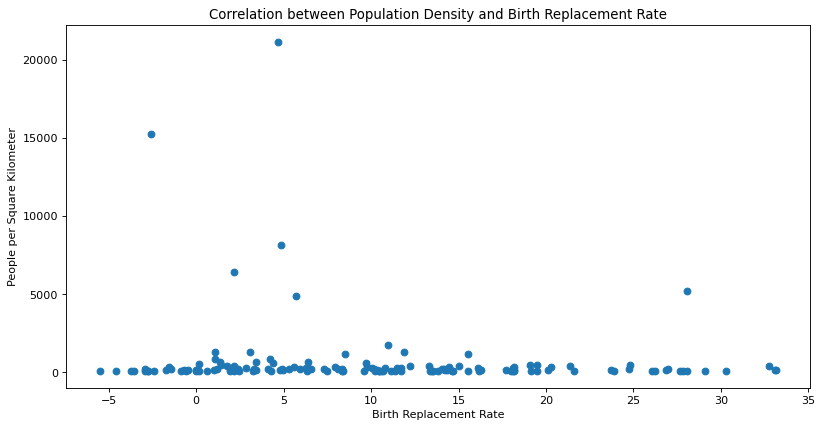

In [26]:
# show a scatter plot of correlation and density
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(data['replacement_rate'], data['pop_density'])
plt.title('Correlation between Population Density and Birth Replacement Rate')
plt.ylabel('People per Square Kilometer')
plt.xlabel('Birth Replacement Rate')
plt.show()

Our data is hard to read because of 6 datapoints with very high population densities. Let's remove those outliers so we can better see what's going on.

In [27]:
# remove outliers so we have a better 
no_out_pop_density = data[data['pop_density'] < 3000]

In [28]:
# show the correlations between series in our dataframe
no_out_pop_density.corr()

,pop_density,replacement_rate
pop_density,1.000000,-0.080736
replacement_rate,-0.080736,1.000000


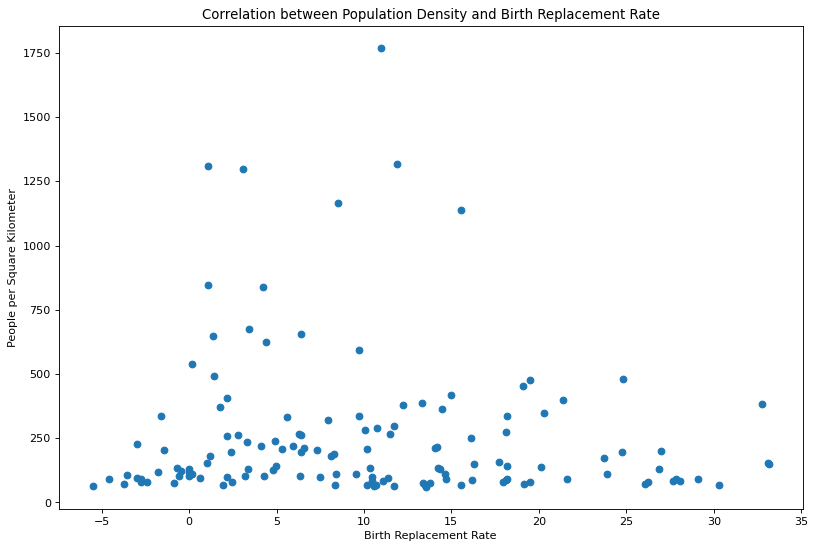

In [29]:
# shoq our scatter plot
plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(no_out_pop_density['replacement_rate'], no_out_pop_density['pop_density'])
plt.title('Correlation between Population Density and Birth Replacement Rate')
plt.ylabel('People per Square Kilometer')
plt.xlabel('Birth Replacement Rate')
plt.show()

Our hypothesis was found to be false. There is not a notable correlation between population_density and birth replacement rates.